## Data Loading & Preprocessing

In [4]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers
import keras_tuner as kt
import tensorflow as tf
from IPython.display import display
from eli5.sklearn import PermutationImportance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from statsmodels.api import OLS

plt.style.use('default')
random_state = 123
np.random.seed(123)

In [5]:
os.chdir('C:/Python/Data')

acc_items_df = pd.read_csv('AP_Compustat_accounting_items_198701_202207.csv')
price_df = pd.read_csv('AP_Compustat_prices_198701_202207_1.csv')
risk_free_rate_df = pd.read_csv('FEDFUNDS.csv', index_col=0)

risk_free_rate_df['FEDFUNDS'] = risk_free_rate_df['FEDFUNDS']/100

acc_items_df['datadate'] = pd.to_datetime(acc_items_df['datadate']).dt.to_period('M')
price_df['datadate'] = pd.to_datetime(price_df['datadate']).dt.to_period('M')
acc_items_df['cusip'] = acc_items_df['cusip'].astype('str')
price_df['cusip'] = price_df['cusip'].astype('str')

# I only keep the companies that are listed on the NYSE, Amex, or NASDAQ-NMS.
USA_listed = [11, 12, 14]
price_df = price_df.loc[price_df['exchg'].isin(USA_listed)]

# I found that there are duplicates appearing in the datasets, so I delete them here.
price_df = price_df.drop_duplicates(subset=['cusip', 'datadate'], keep='first')
acc_items_df = acc_items_df.drop_duplicates(subset=['cusip', 'datadate'], keep='first')

# I only maintain the stocks which possess the stock prices and the accounting items.
list_acc = list(acc_items_df['cusip'].unique())
list_price = list(price_df['cusip'].unique())
list_intersect = list(set(list_acc) & set(list_price))
acc_items_df = acc_items_df[acc_items_df['cusip'].isin(list_intersect)]
price_df = price_df[price_df['cusip'].isin(list_intersect)]

# The dataframe with 21 accounting items (updated quarterly)
acc_21_df = acc_items_df[['datadate', 'cusip', 'acoq', 'aoq', 'atq',
                          'ceqq', 'cheq', 'dlttq', 'dvpq', 'ibadjq',
                          'ibq', 'lcoq', 'loq', 'ltq', 'niq',
                          'nopiq', 'piq', 'ppentq', 'pstkq', 'saleq',
                          'txtq', 'xidoq', 'dvy']]

acc_21_df.set_index(['cusip', 'datadate'], inplace=True)
list_21 = list(acc_21_df.columns)

# The dataframe with stock high, low, close prices and the number of shares outstanding (updated monthly)
price_df = price_df[['datadate', 'cusip', 'prccm', 'prchm', 'prclm', 'trt1m', 'cshom']]
price_df['trt1m'] = price_df['trt1m'] / 100
price_df['Market_Cap'] = price_df['prccm'] * price_df['cshom']
price_df['True_Range'] = np.maximum((price_df['prchm'] - price_df['prclm']), abs(price_df['prchm'] - price_df['prccm']), abs(price_df['prclm'] - price_df['prccm']))
price_df['3m_ATR'] = price_df.groupby('cusip')['True_Range'].transform(lambda x: x.rolling(3, 1).mean())
price_df = price_df[['datadate', 'cusip', 'prccm', 'prchm', 'prclm', 'trt1m', 'cshom', 'True_Range', '3m_ATR', 'Market_Cap']]
price_df.set_index(['cusip', 'datadate'], inplace=True)

## Data Cleaning

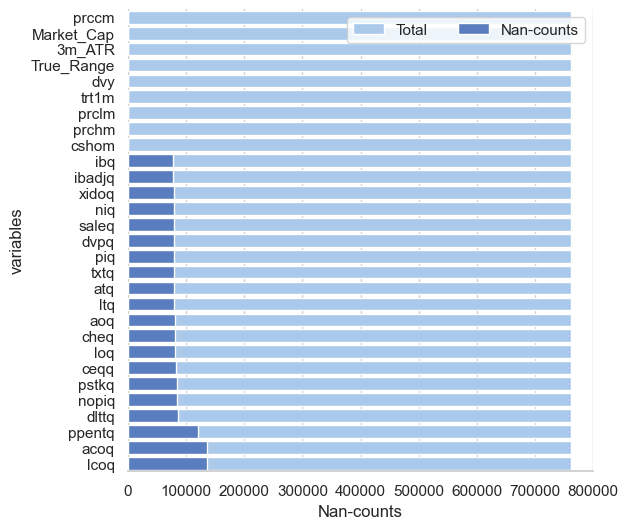

In [6]:
# Combine the two dataframes with applying monthly as the data frequency.
df_21 = price_df.join(acc_21_df, how='left')

# Assume that not until the end of this quarter can I access last quarter's financial data. (3 months later)
# 10-K's deadline can be up to 90 days after the end of the fiscal year-end.
# 10-Q's deadline can be up to 45 days after the end of the quarter-end.
df_21.iloc[:, 8:] = df_21.iloc[:, 8:].groupby(level=0).shift(3)

# Here I forward-fill the accounting items by max 2 months (Convert quarterly data into monthly data).
df_21.loc[:, list_21] = df_21.loc[:, list_21].ffill(limit=2)

# Since I found that sometimes if there is no dividend payment, the dividend payments would be filled with NA instead of 0,
# I chose to transfer all the NA in dvy into 0.
df_21['dvy'] = df_21['dvy'].fillna(0)

# For the data without total returns, I delete them all.
df_21.dropna(subset=['trt1m'], inplace=True)

# For the time-series data without market capitalisation, I delete them from the dataset since they are not predictable and comparable.
df_21.dropna(subset=['cshom', 'Market_Cap'], inplace=True)

# To avoid investing in the illiquid small stocks, I eliminated the micro-cap stocks using a monthly threshold of a 300 million USD market cap.
df_21 = df_21[df_21['Market_Cap'] >= 300000000]

# To avoid investing in the illiquid small stocks, I eliminated the micro-cap stocks using a monthly threshold of a 10 USD share price.
df_21 = df_21[df_21['prccm'] >= 10]

# Check the ratio of missing data in each column
raw = df_21.copy()
nans = pd.DataFrame(raw.isnull().sum())
nans = nans.reset_index()
nans.columns = ['variables', 'Nan-counts']
nans = nans.sort_values('Nan-counts')
nans = nans.reset_index(drop=True)
nans['total'] = raw.shape[0]
sns.set_theme(style='whitegrid')
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
sns.barplot(x='total', y='variables', data=nans, label='Total', color='b')
sns.set_color_codes('muted')
sns.barplot(x='Nan-counts', y='variables', data=nans, label='Nan-counts', color='b')
ax.legend(ncol=2, loc='upper right', frameon=True)
sns.despine(left=True, bottom=False)

## Check the difference in number of companies between the two dataset

In [7]:
# Here I divide the dataframe into a frame with stock returns and a frame with target and features.
df_target_features = df_21.iloc[:, 7:].copy()
df_price_return = df_21.iloc[:, 0:8].copy()

# Here I drop all the missing values in the dataframe with target and features.
df_target_features.dropna(inplace=True)

tickers = list(set(df_price_return.index.get_level_values(0)))
tickers_1 = list(set(df_target_features.index.get_level_values(0)))

print('Number of companies in prices & returns dataset: {:.0f}'.format(len(tickers)))
print('Number of companies in target & features dataset: {:.0f}'.format(len(tickers_1)))

Number of companies in prices & returns dataset: 9178
Number of companies in target & features dataset: 7611


## Keep the companies' prices & returns data only if their corresponding targets & features data exist

In [8]:
# The main reason why I choose to screen the df_price_return with companies' Cusip separately here is that, by doing so,
# I can keep as much return data as possible. For example, if I didn't divide the dataset into two sets when I dropped
# all missing features, I would also delete the return data of the same company in the same month even if only the
# features are missing but the price and return data exist. Then, if I choose to buy the company's stock based on
# its previous month's data, I will not be able to calculate its return for this month. It will cause some problems,
# so I choose to rule out the prices and returns dataset at the company level.

list_intersect_1 = list(set(tickers) & set(tickers_1))
df_price_return = df_price_return[df_price_return.index.get_level_values(0).isin(list_intersect_1)]
df_target_features = df_target_features[df_target_features.index.get_level_values(0).isin(list_intersect_1)]

tickers = list(set(df_price_return.index.get_level_values(0)))
tickers_1 = list(set(df_target_features.index.get_level_values(0)))

print('Number of Companies in Prices & Returns Dataset: {:.0f}'.format(len(tickers)))
print('Number of Companies in Target & Features Dataset: {:.0f}'.format(len(tickers_1)))
# So far I have 7611 companies in both datasets

Number of Companies in Prices & Returns Dataset: 7611
Number of Companies in Target & Features Dataset: 7611


In [ ]:
# Here I generate a return dataframe with year-month as the index and Cusip as the columns
timeline = pd.date_range(start='1998-04-01', end='2022-6-30', freq='M').to_period('M')
df_returns = pd.DataFrame(index=timeline)

for i in tickers:
    df_returns = df_returns.merge(df_price_return.loc[i, 'trt1m'].rename(i), how='left', left_index=True, right_index=True)

df_returns.fillna(0, inplace=True)
df_returns = df_returns.iloc[1:,:]
df_returns.to_csv('AP_returns_data.csv')
list_company = list(df_returns.columns)

In [11]:
display(df_returns.round(4))

,983857103,75382E109,82489T104,28618M106,36164V305,92941V209,48251W104,893641100,524651106,56624R108,...,92346J108,412324303,50736T102,192576106,629579103,74144T108,059815100,372303206,G04561109,68386J208
1998-05,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,-0.0949,0.0,...,0.0000,0.0,0.0,0.0000,-0.1277,-0.0613,-0.1695,0.0000,0.0,0.0
1998-06,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.3624,0.0,...,0.0000,0.0,0.0,0.0000,-0.1177,0.0624,-0.1508,0.0000,0.0,0.0
1998-07,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.1154,0.0,...,0.0000,0.0,0.0,0.0000,-0.1078,-0.0549,-0.1202,0.0000,0.0,0.0
1998-08,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,-0.1925,0.0,...,0.0000,0.0,0.0,0.0000,-0.1722,-0.1426,0.0000,0.0000,0.0,0.0
1998-09,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.4626,0.0,...,0.0000,0.0,0.0,0.0000,0.0499,-0.0321,0.0631,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02,0.0,-0.0749,0.2225,0.0989,0.0,0.0,-0.1531,0.0818,0.0000,0.0,...,0.1582,0.0,0.0,-0.0546,0.0000,-0.0639,0.0000,-0.0182,0.0,0.0
2022-03,0.0,0.0995,0.1700,-0.1090,0.0,0.0,-0.0274,-0.0226,0.0000,0.0,...,-0.0726,0.0,0.0,-0.0507,0.0000,0.0542,0.0000,0.0813,0.0,0.0
2022-04,0.0,-0.3120,-0.2712,-0.0584,0.0,0.0,-0.1283,-0.0871,0.0000,0.0,...,-0.2543,0.0,0.0,-0.1027,0.0000,-0.1862,0.0000,-0.0276,0.0,0.0
2022-05,0.0,-0.0271,0.0865,0.0364,0.0,0.0,0.0784,0.0178,0.0000,0.0,...,-0.0474,0.0,0.0,0.1457,0.2565,0.0329,0.0000,-0.1401,0.0,0.0


In [ ]:
# Here I generate a market cap dataframe with year-month as the index and Cusip as the columns
timeline = pd.date_range(start='1998-04-01', end='2022-6-30', freq='M').to_period('M')
df_market_cap = pd.DataFrame(index=timeline)

for i in tickers:
    df_market_cap = df_market_cap.merge(df_price_return.loc[i, 'Market_Cap'].rename(i), how='left', left_index=True, right_index=True)

df_market_cap.fillna(0, inplace=True)
df_market_cap = df_market_cap.iloc[1:,:]
df_market_cap.to_csv('AP_market_cap_data.csv')


In [13]:
display(df_market_cap)

,983857103,75382E109,82489T104,28618M106,36164V305,92941V209,48251W104,893641100,524651106,56624R108,...,92346J108,412324303,50736T102,192576106,629579103,74144T108,059815100,372303206,G04561109,68386J208
1998-05,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1.040175e+09,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,952250000.0,4.212668e+09,451168750.0,0.000000e+00,0.0,0.0
1998-06,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1.417182e+09,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,840125000.0,4.465280e+09,380445000.0,0.000000e+00,0.0,0.0
1998-07,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1.580703e+09,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,749531250.0,4.243528e+09,334718437.5,0.000000e+00,0.0,0.0
1998-08,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1.293689e+09,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,619506000.0,3.638377e+09,0.0,0.000000e+00,0.0,0.0
1998-09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1.892193e+09,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,650400000.0,3.511370e+09,307498750.0,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02,0.0,590920000.0,6.256928e+09,6.099847e+09,0.0,0.0,3.517074e+10,3.697041e+10,0.000000e+00,0.0,...,1.929246e+09,0.0,0.0,1.514226e+09,0.0,3.313315e+10,0.0,2.199460e+09,0.0,0.0
2022-03,0.0,650310270.0,7.393213e+09,5.434770e+09,0.0,0.0,3.456425e+10,3.613571e+10,0.000000e+00,0.0,...,1.797678e+09,0.0,0.0,1.437494e+09,0.0,3.444259e+10,0.0,2.378256e+09,0.0,0.0
2022-04,0.0,447711830.0,5.388389e+09,5.117121e+09,0.0,0.0,3.013066e+10,3.298935e+10,0.000000e+00,0.0,...,1.340498e+09,0.0,0.0,1.289860e+09,0.0,2.802974e+10,0.0,2.312522e+09,0.0,0.0
2022-05,0.0,436359680.0,5.877404e+09,5.273831e+09,0.0,0.0,3.248079e+10,3.304412e+10,0.000000e+00,0.0,...,1.279308e+09,0.0,0.0,1.479933e+09,332409780.0,2.888718e+10,0.0,1.989028e+09,0.0,0.0


## For simplicity in the following process

In [ ]:
quintile_position = np.repeat([-1, 0, 1], [1, 3, 1]).tolist()
decile_position = np.repeat([-1, 0, 1], [1, 8, 1]).tolist()
twenths_position = np.repeat([-1, 0, 1], [1, 18, 1]).tolist()
percentile_position = np.repeat([-1, 0, 1], [1, 98, 1]).tolist()
quintile_rank = list(range(0, 5))
decile_rank = list(range(0, 10))
twenths_rank = list(range(0, 20))
percentile_rank = list(range(0, 100))
x = [str(year) for year in list(range(1999, 2023))]
feature_names = list(df_target_features.columns)[1:]